## Setup and Imports

In [34]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# --- Configuration (using MLflow tiny model) ---
BATCH_SIZE = 16
MODEL_NAME = 'vit_tiny_patch16_224'
MODEL_PATH = 'mlflow_vitsmall/mlflow_vit/423964100717433275/3ec8c39304544c90b286b93f5ee79e62/artifacts/state_dict_vit.pt'

# Number of classes the model was trained on (full PlantVillage = 38)
MODEL_NUM_CLASSES = 38

print("⚡ Configuration Loaded")
print(f"   - Model: {MODEL_NAME}")
print(f"   - Model path: {MODEL_PATH}")
print(f"   - Model trained on: {MODEL_NUM_CLASSES} classes\n")

# --- Data Transforms ---
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Load Data ---
test_dir = 'vit_data/test'
train_dir = 'vit_data/train'

train_dataset = datasets.ImageFolder(train_dir, data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Dataset class names (17 classes available in our data)
class_names = test_dataset.classes
NUM_CLASSES = len(class_names)

# Full PlantVillage class names (38 classes - what the model was trained on)
full_class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
    'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
    'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
    'Raspberry___healthy', 'Soybean___healthy',
    'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

# Create mapping from dataset class index to model class index
dataset_to_model_idx = {}
model_to_dataset_idx = {}
for i, name in enumerate(class_names):
    if name in full_class_names:
        model_idx = full_class_names.index(name)
        dataset_to_model_idx[i] = model_idx
        model_to_dataset_idx[model_idx] = i
    else:
        print(f"⚠️ Warning: {name} not found in full class list")

print(f"📊 Dataset Info:")
print(f"   Test dataset size: {len(test_dataset)}")
print(f"   Available classes: {NUM_CLASSES}")
print(f"   Class names: {class_names}")

⚡ Configuration Loaded
   - Model: vit_tiny_patch16_224
   - Model path: mlflow_vitsmall/mlflow_vit/423964100717433275/3ec8c39304544c90b286b93f5ee79e62/artifacts/state_dict_vit.pt
   - Model trained on: 38 classes

📊 Dataset Info:
   Test dataset size: 5923
   Available classes: 17
   Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## Load Trained Model

In [35]:
# --- Load Model ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model architecture (vit_tiny)
model_ft = timm.create_model(MODEL_NAME, pretrained=False, drop_rate=0.2)

# Replace head with the correct number of classes (model trained on 38)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, MODEL_NUM_CLASSES)
)

# Load trained weights from MLflow
model_ft.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=False))
model_ft = model_ft.to(device)
model_ft.eval()

print("✅ Model loaded successfully!")
print(f"   Model architecture: {MODEL_NAME}")
print(f"   Model output classes: {MODEL_NUM_CLASSES}")
print(f"   Evaluating on: {NUM_CLASSES} classes (subset)")

Using device: cpu
✅ Model loaded successfully!
   Model architecture: vit_tiny_patch16_224
   Model output classes: 38
   Evaluating on: 17 classes (subset)


## Evaluate Model on Test Set

First, let's run predictions on the test set to get baseline metrics.

In [36]:
# Evaluate the model on the test set
# Model outputs 38 classes, we map to our 17 classes

model_ft.eval()
test_corrects = 0
test_total = 0
all_test_preds = []
all_test_labels = []

print("📊 Evaluating model on test set...")

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        # Map dataset labels to model indices for comparison
        mapped_labels = torch.tensor([dataset_to_model_idx[l.item()] for l in labels]).to(device)
        
        test_corrects += torch.sum(predicted_classes == mapped_labels).item()
        test_total += labels.size(0)
        
        # Store predictions mapped back to dataset indices (0-16)
        for pred in predicted_classes.cpu().numpy():
            if pred in model_to_dataset_idx:
                all_test_preds.append(model_to_dataset_idx[pred])
            else:
                all_test_preds.append(-1)  # Prediction outside our 17 classes
        all_test_labels.extend(labels.cpu().numpy())

test_acc = test_corrects / test_total
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
print(f'\n🎯 Test Results:')
print(f'   Accuracy: {test_acc:.4f}')
print(f'   F1 (macro): {test_f1:.4f}')

📊 Evaluating model on test set...


Testing:   0%|          | 0/371 [00:00<?, ?it/s]

Testing: 100%|██████████| 371/371 [04:16<00:00,  1.45it/s]



🎯 Test Results:
   Accuracy: 0.9529
   F1 (macro): 0.9058


## Install Interpretability Packages

In [37]:
# Install required packages for interpretability
!pip install grad-cam shap pillow

## Helper Functions

In [38]:
import cv2
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import shap
import random

# Helper function to get a sample image
def get_sample_image(dataset, class_name=None):
    """Get a random image from the dataset, optionally from a specific class"""
    if class_name:
        class_idx = dataset.classes.index(class_name)
        indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
        idx = random.choice(indices)
    else:
        idx = random.randint(0, len(dataset) - 1)
    
    img_path, label = dataset.samples[idx]
    img = Image.open(img_path).convert('RGB')
    return img, label, img_path

# Helper function to denormalize image for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize a tensor image"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


## Grad-CAM 

In [39]:
# Setup Grad-CAM for Vision Transformer
# For ViT, we target the last block's normalization layer

def reshape_transform_vit(tensor, height=14, width=14):
    """Reshape transformer output for Grad-CAM"""
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Target the last transformer block's layer norm
target_layers = [model_ft.blocks[-1].norm1]

# Initialize Grad-CAM
cam = GradCAM(model=model_ft, target_layers=target_layers, reshape_transform=reshape_transform_vit)

print("Grad-CAM initialized successfully!")

Grad-CAM initialized successfully!


Generating Grad-CAM visualizations


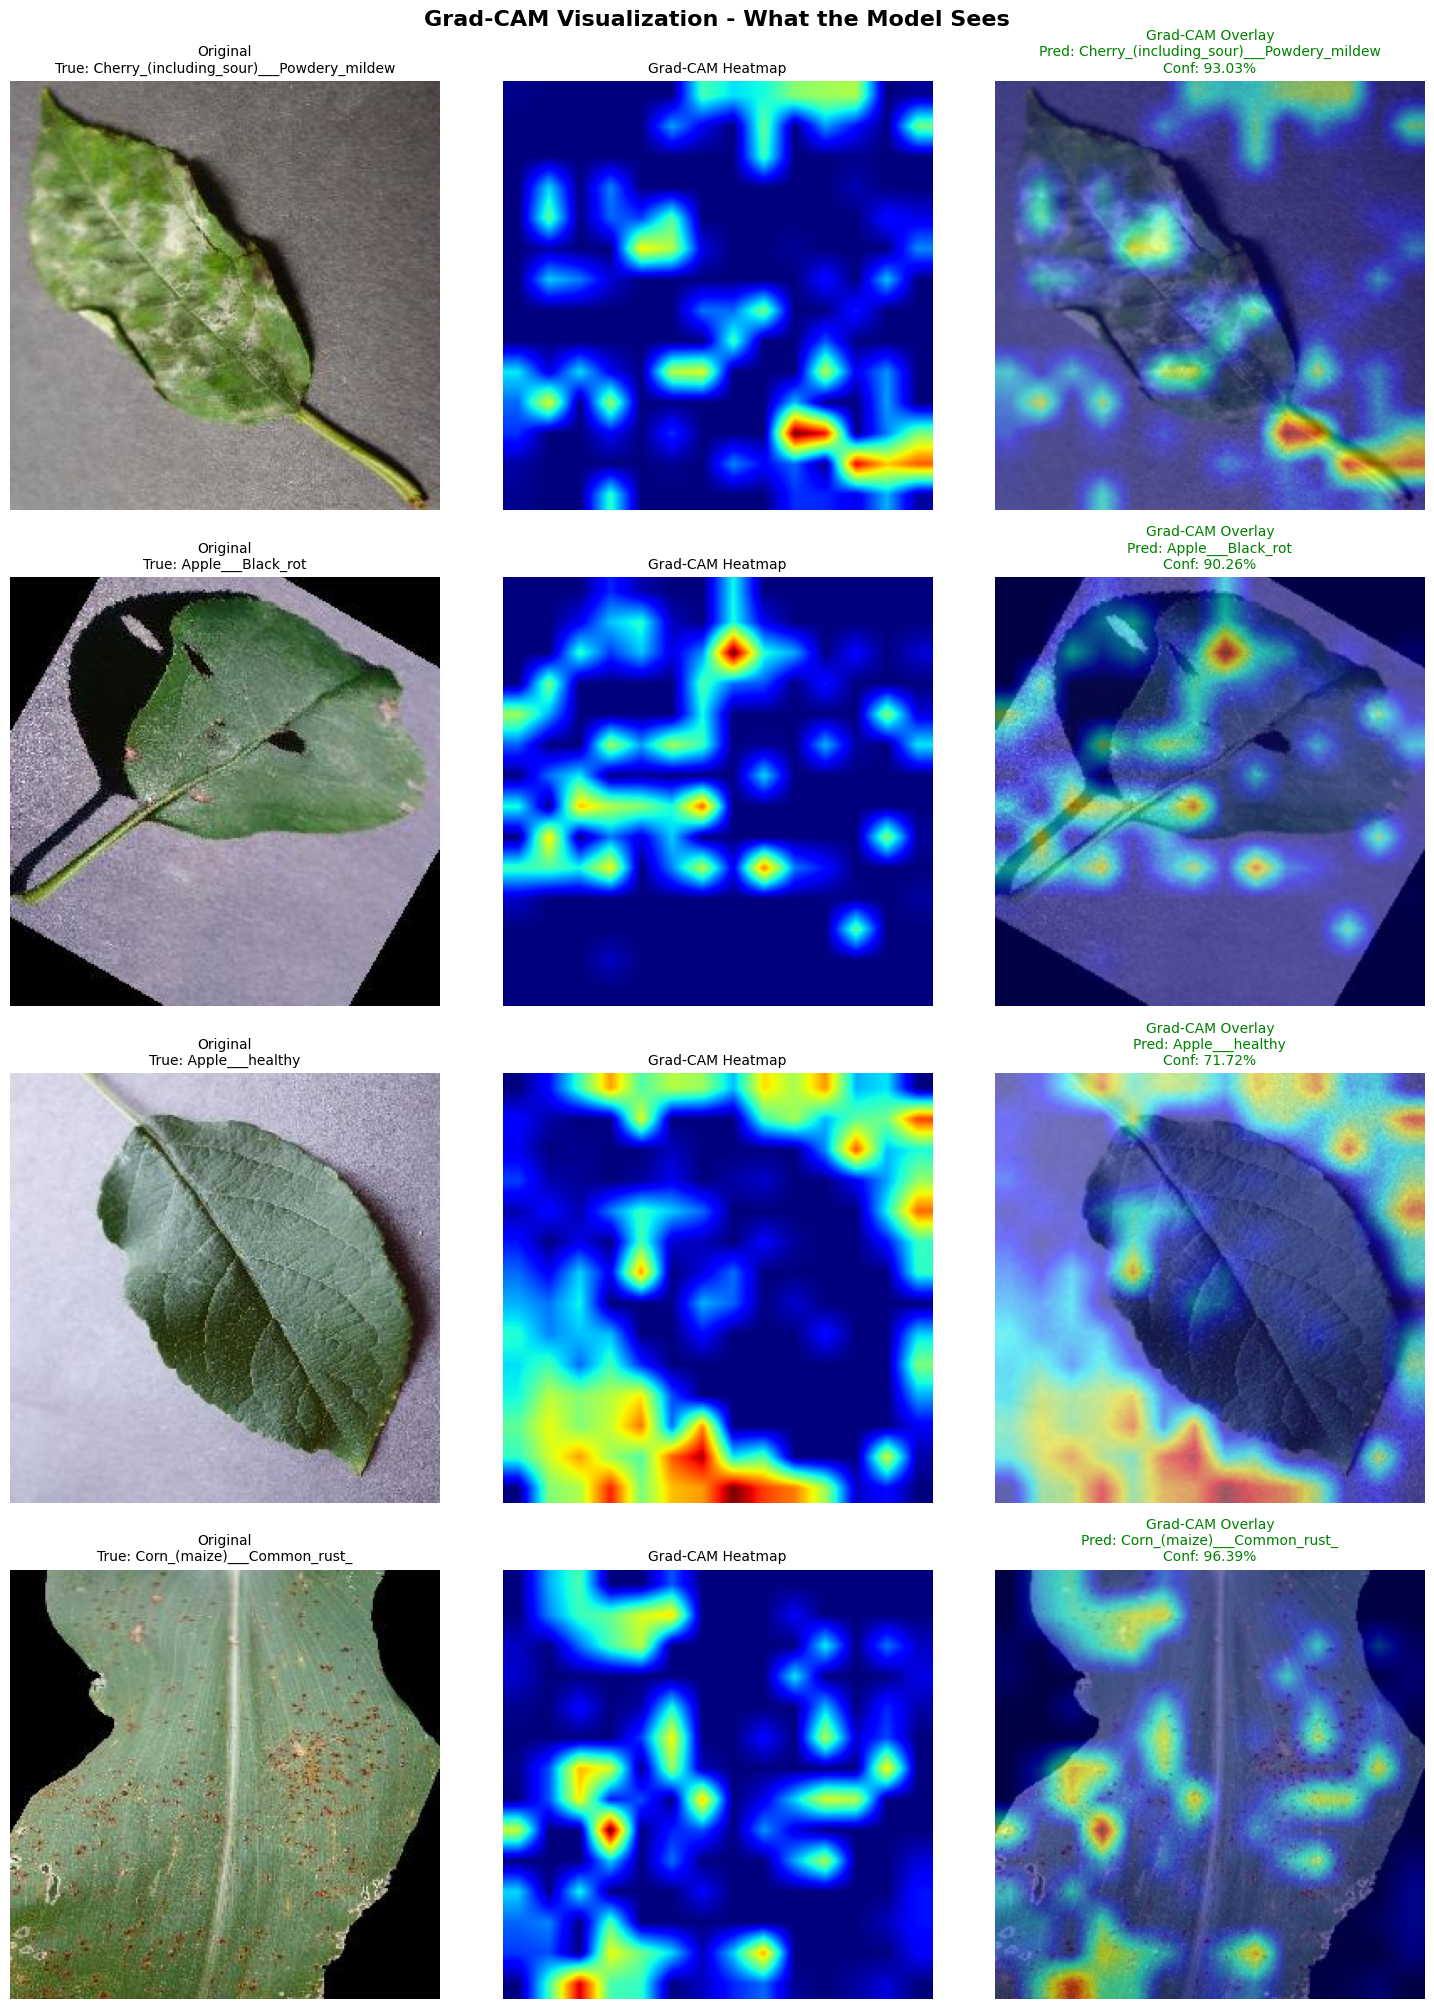


Grad-CAM visualizations show which regions of the image
the model focuses on when making predictions (red = high importance)


In [40]:
# Visualize Grad-CAM for sample images from different classes
num_samples = 4
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
print("Generating Grad-CAM visualizations")

# Select random classes to visualize
selected_classes = random.sample(class_names, min(num_samples, len(class_names)))

for idx, class_name in enumerate(selected_classes):
    # Get a sample image from the test set
    img, label, img_path = get_sample_image(test_dataset, class_name)
    
    # Preprocess for model
    input_tensor = data_transforms['val'](img).unsqueeze(0).to(device)
    
    # Get model prediction
    model_ft.eval()
    with torch.no_grad():
        output = model_ft(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        pred_model_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, pred_model_idx].item()
    
    # Map prediction to dataset class name
    if pred_model_idx in model_to_dataset_idx:
        pred_name = class_names[model_to_dataset_idx[pred_model_idx]]
    else:
        pred_name = full_class_names[pred_model_idx] + " (not in dataset)"
    
    # Generate Grad-CAM
    targets = [ClassifierOutputTarget(pred_model_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Convert image to numpy for visualization
    img_np = np.array(img.resize((224, 224))) / 255.0
    
    # Overlay Grad-CAM on image
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    
    # Plot: Original, Grad-CAM heatmap, Overlay
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f'Original\nTrue: {class_names[label]}', fontsize=10)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(grayscale_cam, cmap='jet')
    axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=10)
    axes[idx, 1].axis('off')
    
    # Check if prediction is correct
    true_model_idx = dataset_to_model_idx[label]
    color = 'green' if pred_model_idx == true_model_idx else 'red'
    axes[idx, 2].imshow(visualization)
    axes[idx, 2].set_title(f'Grad-CAM Overlay\nPred: {pred_name}\nConf: {confidence:.2%}', 
                           fontsize=10, color=color)
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.suptitle('Grad-CAM Visualization - What the Model Sees', fontsize=16, fontweight='bold', y=1.002)
plt.show()

print("\nGrad-CAM visualizations show which regions of the image")
print("the model focuses on when making predictions (red = high importance)")

## SHAP (DeepSHAP) Analysis

SHAP provides pixel-level importance scores showing which pixels contribute positively or negatively to the prediction.

In [41]:
# Prepare background data for SHAP (CPU optimized - reduced samples)
print("⏳ Initializing SHAP (this is the slowest part, ~3-5 minutes)...")
print("Using GradientSHAP (more compatible with Vision Transformers)\n")
background_size = 10  # Reduced from 50 to 10 for CPU
background_data = []

# Collect background samples
for i in tqdm(range(min(background_size, len(test_dataset))), desc="Loading background samples"):
    img, _ = test_dataset[i]
    background_data.append(img.unsqueeze(0))

background = torch.cat(background_data, dim=0).to(device)

# Create SHAP explainer - Using GradientSHAP for better ViT support
e = shap.GradientExplainer(model_ft, background)

print(f"GradientSHAP explainer initialized with {background_size} background samples")

⏳ Initializing SHAP (this is the slowest part, ~3-5 minutes)...
Using GradientSHAP (more compatible with Vision Transformers)



Loading background samples: 100%|██████████| 10/10 [00:00<00:00, 86.49it/s]


GradientSHAP explainer initialized with 10 background samples


🧠 Computing SHAP values (2-4 minutes per sample)...
  → Processing sample 1/2...
  SHAP values shape: (1, 3, 224, 224, 38)
  → Processing sample 2/2...


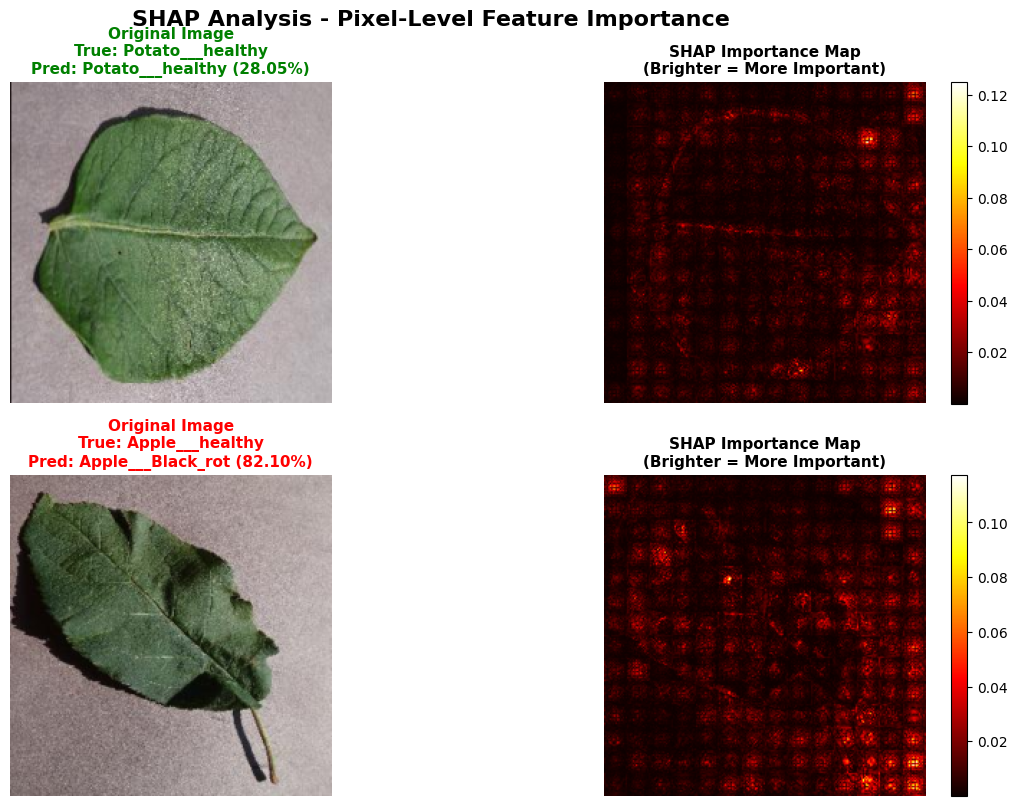


SHAP values show pixel-level importance:
- Brighter regions in the heatmap indicate higher importance
- These pixels have the most influence on the model's prediction


In [42]:
# Generate SHAP explanations for sample images
num_shap_samples = 2
fig, axes = plt.subplots(num_shap_samples, 2, figsize=(12, num_shap_samples * 4))
print("🧠 Computing SHAP values (2-4 minutes per sample)...")

for idx in range(num_shap_samples):
    print(f"  → Processing sample {idx+1}/{num_shap_samples}...")
    # Get a random test image
    img, label, img_path = get_sample_image(test_dataset)
    
    # Preprocess for model
    input_tensor = data_transforms['val'](img).unsqueeze(0).to(device)
    
    # Get prediction
    model_ft.eval()
    with torch.no_grad():
        output = model_ft(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        pred_model_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, pred_model_idx].item()
    
    # Map prediction to class name
    if pred_model_idx in model_to_dataset_idx:
        pred_name = class_names[model_to_dataset_idx[pred_model_idx]]
    else:
        pred_name = full_class_names[pred_model_idx] + " (outside)"
    
    # Compute SHAP values
    shap_values = e.shap_values(input_tensor, nsamples=50)
    
    # Debug shape
    if idx == 0:
        if isinstance(shap_values, list):
            print(f"  SHAP values: list of {len(shap_values)} arrays, shape: {shap_values[0].shape}")
        else:
            print(f"  SHAP values shape: {shap_values.shape}")
    
    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        shap_numpy = shap_values[pred_model_idx]
        if len(shap_numpy.shape) == 4:
            shap_sum = np.abs(shap_numpy[0]).sum(axis=0)
        else:
            shap_sum = np.abs(shap_numpy).sum(axis=0)
    else:
        if len(shap_values.shape) == 5:
            shap_for_class = shap_values[0, :, :, :, pred_model_idx]
            shap_sum = np.abs(shap_for_class).sum(axis=0)
        elif len(shap_values.shape) == 4:
            shap_sum = np.abs(shap_values[0]).sum(axis=0)
        elif len(shap_values.shape) == 3:
            shap_sum = np.abs(shap_values).sum(axis=0)
        else:
            shap_sum = np.abs(shap_values)
    
    # Denormalize for visualization
    img_denorm = denormalize(input_tensor[0].cpu())
    img_denorm_np = img_denorm.permute(1, 2, 0).numpy()
    
    # Check if correct
    true_model_idx = dataset_to_model_idx[label]
    color = 'green' if pred_model_idx == true_model_idx else 'red'
    
    # Plot original image
    axes[idx, 0].imshow(img_denorm_np)
    axes[idx, 0].set_title(f'Original Image\nTrue: {class_names[label]}\nPred: {pred_name} ({confidence:.2%})', 
                           fontsize=11, fontweight='bold', color=color)
    axes[idx, 0].axis('off')
    
    # Plot SHAP values as heatmap
    im = axes[idx, 1].imshow(shap_sum, cmap='hot', interpolation='bilinear')
    axes[idx, 1].set_title('SHAP Importance Map\n(Brighter = More Important)', fontsize=11, fontweight='bold')
    axes[idx, 1].axis('off')
    plt.colorbar(im, ax=axes[idx, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle('SHAP Analysis - Pixel-Level Feature Importance', fontsize=16, fontweight='bold', y=1.002)
plt.show()

print("\nSHAP values show pixel-level importance:")
print("- Brighter regions in the heatmap indicate higher importance")
print("- These pixels have the most influence on the model's prediction")

## Detailed SHAP Analysis for a Specific Image

Let's examine one image in detail with multiple visualization styles.

🎯 Generating detailed SHAP analysis (3-5 minutes)...


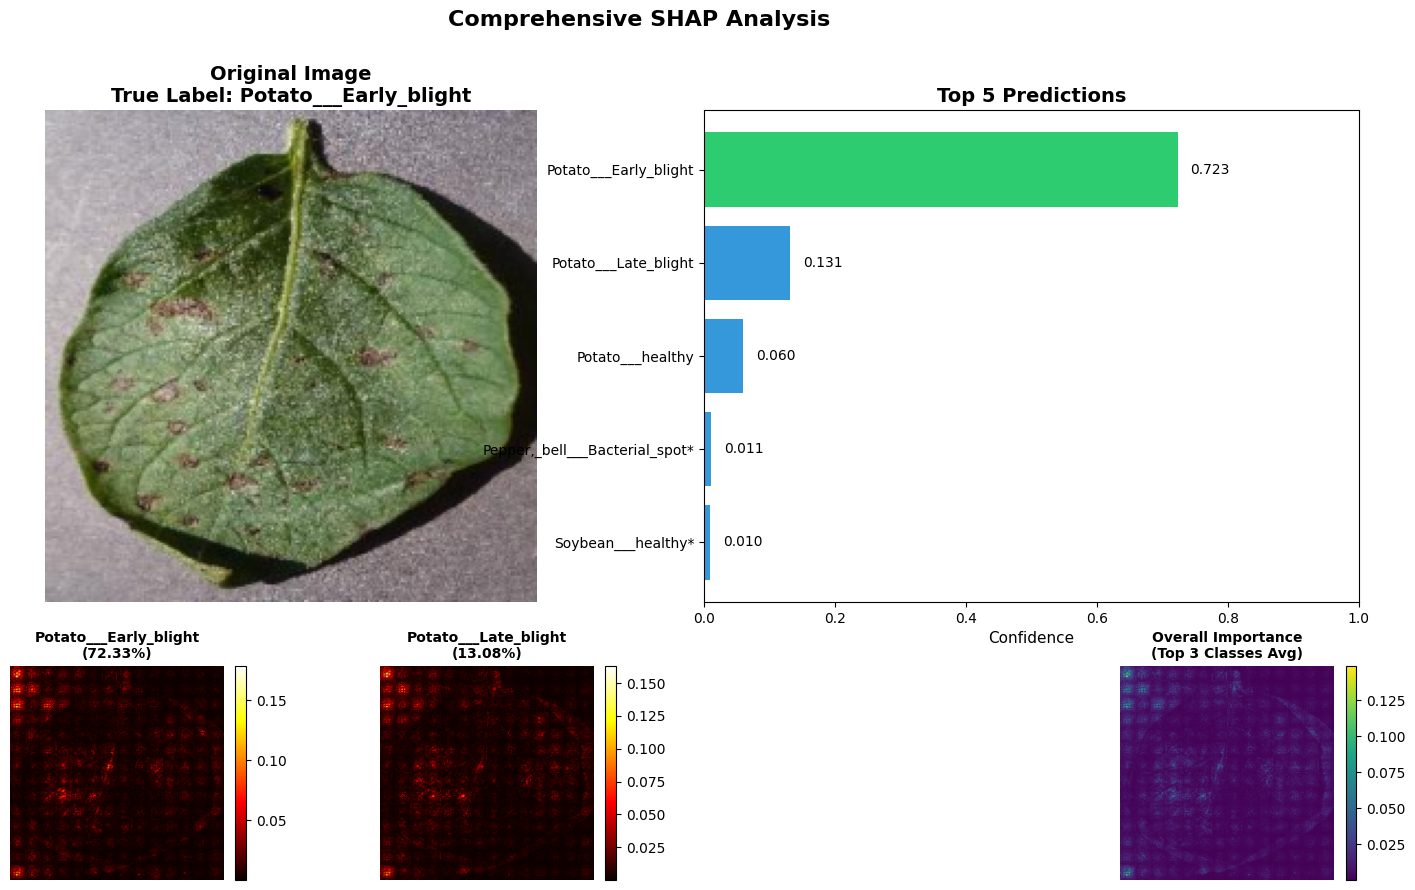


Image: vit_data/test\Potato___Early_blight\33019904-ac3b-4083-a192-ce4092758ddd___RS_Early.B 8344_180deg.JPG
True label: Potato___Early_blight
Predicted: Potato___Early_blight with 72.33% confidence

* = class outside available dataset

Interpretation:
- Top section shows the original image and model's predictions
- Bottom row shows SHAP importance maps for the top 2 predicted classes
- Warmer colors (red/yellow) indicate pixels that strongly influence the prediction


In [43]:
# Detailed SHAP analysis for one image
print("🎯 Generating detailed SHAP analysis (3-5 minutes)...")
img, label, img_path = get_sample_image(test_dataset)

# Preprocess
input_tensor = data_transforms['val'](img).unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model_ft(input_tensor)
    probabilities = torch.softmax(output, dim=1)
    pred_model_idx = torch.argmax(probabilities, dim=1).item()
    top5_probs, top5_indices = torch.topk(probabilities[0], 5)

# Compute SHAP values
shap_values = e.shap_values(input_tensor)

# Helper function to extract SHAP heatmap for a specific class
def get_shap_heatmap(shap_vals, class_idx):
    """Extract 2D heatmap from SHAP values for a specific class"""
    if isinstance(shap_vals, list):
        sv = shap_vals[class_idx]
        if len(sv.shape) == 4:
            return np.abs(sv[0]).sum(axis=0)
        elif len(sv.shape) == 3:
            return np.abs(sv).sum(axis=0)
        else:
            return np.abs(sv)
    else:
        if len(shap_vals.shape) == 5:
            return np.abs(shap_vals[0, :, :, :, class_idx]).sum(axis=0)
        elif len(shap_vals.shape) == 4:
            return np.abs(shap_vals[0]).sum(axis=0)
        elif len(shap_vals.shape) == 3:
            return np.abs(shap_vals).sum(axis=0)
        else:
            return np.abs(shap_vals)

# Helper to get class name from model index
def get_class_name(model_idx):
    if model_idx in model_to_dataset_idx:
        return class_names[model_to_dataset_idx[model_idx]]
    return full_class_names[model_idx] + "*"

# Prepare for visualization
img_denorm = denormalize(input_tensor[0].cpu())
img_denorm_np = img_denorm.permute(1, 2, 0).numpy()

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Original image
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax1.imshow(img_denorm_np)
ax1.set_title(f'Original Image\nTrue Label: {class_names[label]}', fontsize=14, fontweight='bold')
ax1.axis('off')

# Top 5 predictions
ax2 = fig.add_subplot(gs[0:2, 2:4])
y_pos = np.arange(5)
true_model_idx = dataset_to_model_idx[label]
colors = ['#2ecc71' if top5_indices[i].item() == true_model_idx else '#3498db' for i in range(5)]
ax2.barh(y_pos, top5_probs.cpu().numpy(), color=colors)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([get_class_name(idx.item()) for idx in top5_indices])
ax2.invert_yaxis()
ax2.set_xlabel('Confidence', fontsize=11)
ax2.set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
for i, v in enumerate(top5_probs.cpu().numpy()):
    ax2.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10)

# SHAP heatmaps for top 2 classes
for i in range(2):
    class_idx = top5_indices[i].item()
    shap_for_class = get_shap_heatmap(shap_values, class_idx)
    
    ax = fig.add_subplot(gs[2, i])
    im = ax.imshow(shap_for_class, cmap='hot', interpolation='bilinear')
    ax.set_title(f'{get_class_name(class_idx)}\n({top5_probs[i].item():.2%})', fontsize=10, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Overall SHAP importance (average across top 3 classes)
ax4 = fig.add_subplot(gs[2, 3])
class_importances = []
for i in range(min(3, len(top5_indices))):
    class_idx = top5_indices[i].item()
    class_importances.append(get_shap_heatmap(shap_values, class_idx))
overall_shap = np.mean(class_importances, axis=0)

im = ax4.imshow(overall_shap, cmap='viridis', interpolation='bilinear')
ax4.set_title('Overall Importance\n(Top 3 Classes Avg)', fontsize=10, fontweight='bold')
ax4.axis('off')
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

plt.suptitle('Comprehensive SHAP Analysis', fontsize=16, fontweight='bold')
plt.show()

pred_name = get_class_name(pred_model_idx)
print(f"\nImage: {img_path}")
print(f"True label: {class_names[label]}")
print(f"Predicted: {pred_name} with {top5_probs[0].item():.2%} confidence")
print("\n* = class outside available dataset")
print("\nInterpretation:")
print("- Top section shows the original image and model's predictions")
print("- Bottom row shows SHAP importance maps for the top 2 predicted classes")
print("- Warmer colors (red/yellow) indicate pixels that strongly influence the prediction")

## Confusion Matrix with Interpretability Insights

Combine confusion matrix analysis with interpretability for misclassified examples.

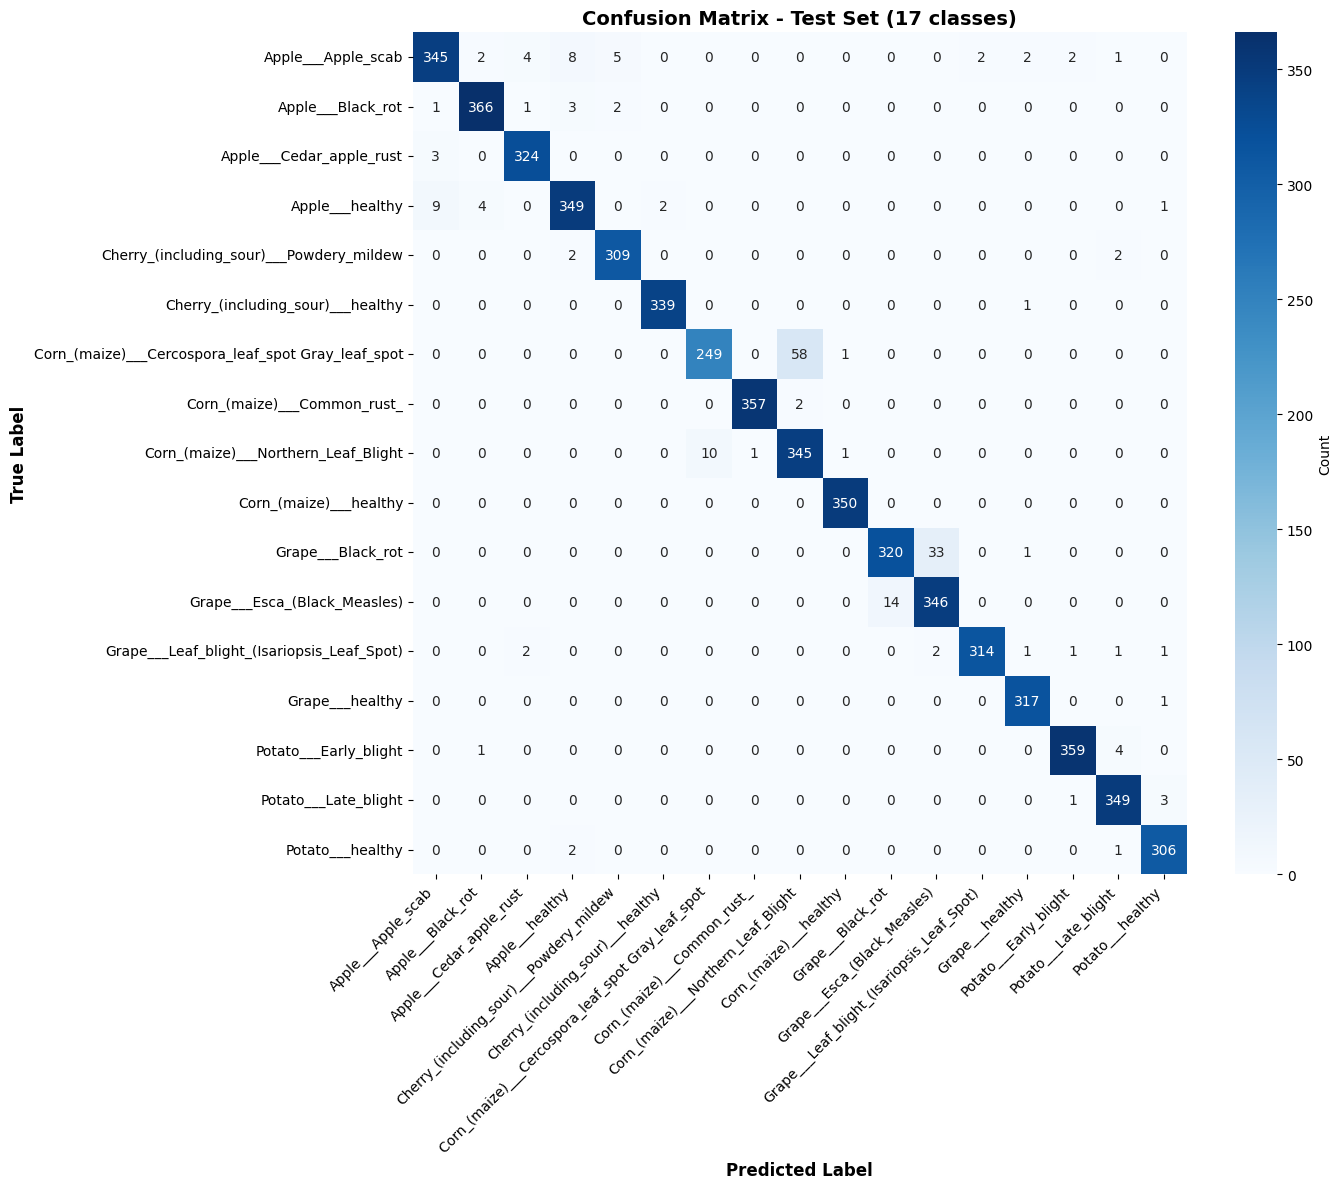

Confusion Matrix Analysis:
Total test samples: 5923
Correctly classified: 5644
Misclassified (within 17 classes): 199
Predicted outside available classes: 80


In [44]:
# Generate confusion matrix for 17 classes
# Filter out predictions outside our 17 classes
valid_mask = [p != -1 for p in all_test_preds]
filtered_preds = [p for p, v in zip(all_test_preds, valid_mask) if v]
filtered_labels = [l for l, v in zip(all_test_labels, valid_mask) if v]
outside_count = sum(1 for p in all_test_preds if p == -1)

cm = confusion_matrix(filtered_labels, filtered_preds, labels=list(range(NUM_CLASSES)))

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - Test Set ({NUM_CLASSES} classes)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate metrics
correct = np.trace(cm)
total = len(all_test_labels)

print("Confusion Matrix Analysis:")
print(f"Total test samples: {total}")
print(f"Correctly classified: {correct}")
print(f"Misclassified (within {NUM_CLASSES} classes): {len(filtered_labels) - correct}")
if outside_count > 0:
    print(f"Predicted outside available classes: {outside_count}")

## Analyzing Misclassified Examples with Grad-CAM

🔍 Searching for misclassified examples...


Scanning batches:   1%|          | 3/371 [00:03<06:45,  1.10s/it]


Analyzing misclassified examples with Grad-CAM ...


Generating Grad-CAM: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]


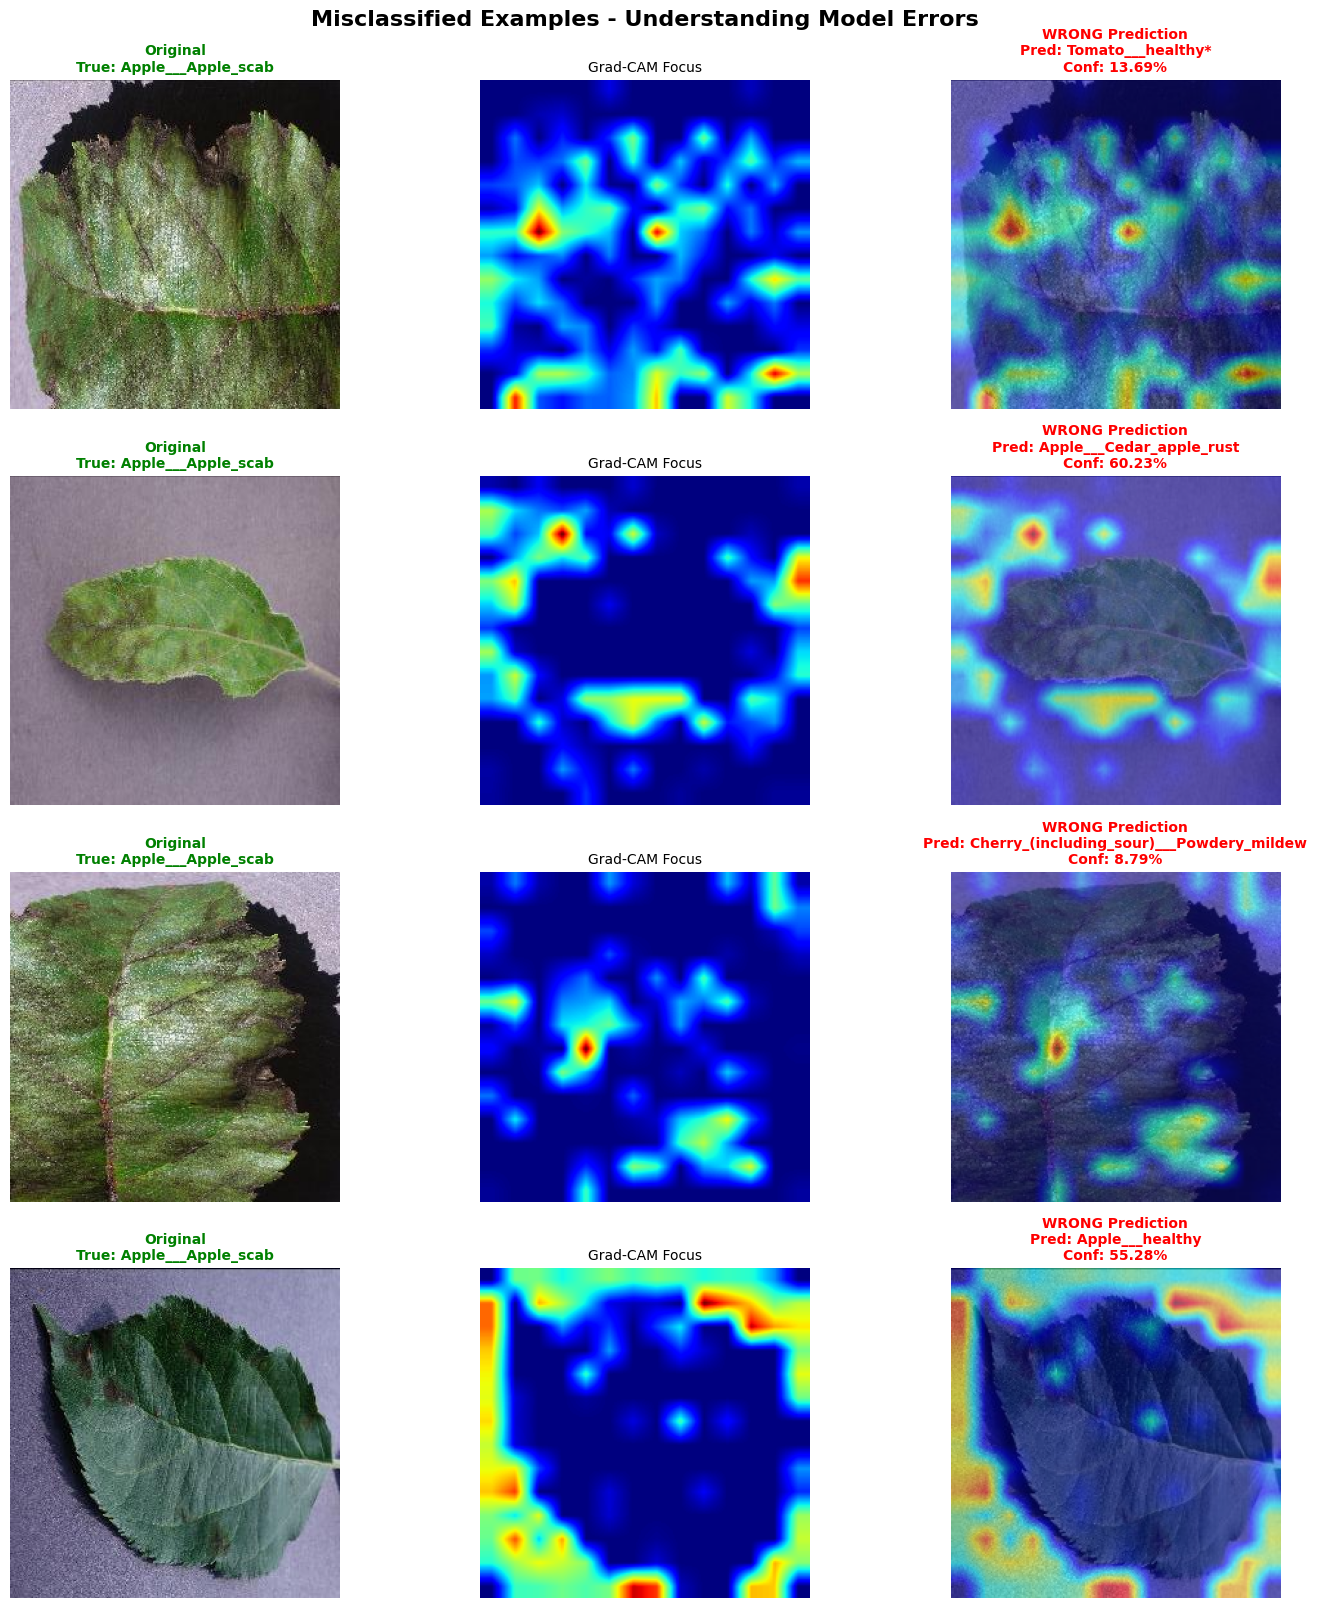


Found 5 misclassified examples in test set
* = prediction outside available 17 classes
These visualizations help understand where the model focuses when making incorrect predictions


In [45]:
# Find and visualize misclassified examples with interpretability
model_ft.eval()
misclassified = []

print("🔍 Searching for misclassified examples...")
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(test_loader, desc="Scanning batches")):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Map dataset labels to model indices
        mapped_labels = torch.tensor([dataset_to_model_idx[l.item()] for l in labels]).to(device)
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Find misclassified samples
        for j in range(len(labels)):
            if preds[j] != mapped_labels[j]:
                idx = i * BATCH_SIZE + j
                if idx < len(test_dataset):
                    misclassified.append((idx, labels[j].item(), preds[j].item()))
        
        if len(misclassified) >= 4:
            break

# Visualize misclassified examples with Grad-CAM
print("Analyzing misclassified examples with Grad-CAM ...")
if len(misclassified) > 0:
    num_display = min(4, len(misclassified))
    fig, axes = plt.subplots(num_display, 3, figsize=(15, num_display * 4))
    
    if num_display == 1:
        axes = axes.reshape(1, -1)
    
    sample_indices = random.sample(misclassified, num_display)
    for idx, (sample_idx, true_label, pred_model_idx) in enumerate(tqdm(sample_indices, desc="Generating Grad-CAM")):
        img_path, _ = test_dataset.samples[sample_idx]
        img = Image.open(img_path).convert('RGB')
        
        # Preprocess
        input_tensor = data_transforms['val'](img).unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model_ft(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            pred_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0, pred_class].item()
        
        # Get prediction name
        if pred_class in model_to_dataset_idx:
            pred_name = class_names[model_to_dataset_idx[pred_class]]
        else:
            pred_name = full_class_names[pred_class] + "*"
        
        # Generate Grad-CAM
        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        img_np = np.array(img.resize((224, 224))) / 255.0
        visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        
        # Plot
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Original\nTrue: {class_names[true_label]}', fontsize=10, color='green', fontweight='bold')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(grayscale_cam, cmap='jet')
        axes[idx, 1].set_title('Grad-CAM Focus', fontsize=10)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(visualization)
        axes[idx, 2].set_title(f'WRONG Prediction\nPred: {pred_name}\nConf: {confidence:.2%}', 
                              fontsize=10, color='red', fontweight='bold')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Misclassified Examples - Understanding Model Errors', fontsize=16, fontweight='bold', y=1.002)
    plt.show()
    
    print(f"\nFound {len(misclassified)} misclassified examples in test set")
    print("* = prediction outside available 17 classes")
    print("These visualizations help understand where the model focuses when making incorrect predictions")
else:
    print("No misclassified examples found in the test set!")

## Summary

**Key Insights from Interpretability Analysis:**

1. **Grad-CAM** shows spatial attention - which regions of the image the ViT model focuses on
   - Red/warm colors indicate high importance regions
   - Helps verify the model is looking at relevant features (e.g., leaves, disease symptoms)

2. **SHAP** provides pixel-level explanations of feature importance
   - Shows positive and negative contributions to predictions
   - Helps understand fine-grained decision making

3. **Misclassification Analysis** reveals:
   - Where the model makes mistakes
   - Whether it focuses on wrong regions
   - Potential data quality or class confusion issues

These interpretability tools help build trust in the model and identify areas for improvement.